# Predicting House Prices

... some description ...

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from scipy import stats

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
sns.set_style('darkgrid')
pd.options.display.precision = 5

In [3]:
houses = pd.read_csv('AmesHousing.tsv', delimiter='\t')
houses = houses.sample(frac=1, random_state=1).reset_index(drop=True)
houses.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0   2127  907135180           20        RL          60.0      8070   Pave   
1    193  903206120           75        RL           NaN      7793   Pave   
2   2407  528181040          120        RL          40.0      6792   Pave   
3     46  528175010          120        RL          44.0      6371   Pave   
4   2478  531379030           60        RL          70.0      8304   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       IR1          Bnk  ...         0     NaN    NaN          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
3   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  GdPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       8    2007       WD           Normal     123600  
1        0       5    2010       WD           Normal     209500  
2        0       3    2006       New         Partial     202665  
3        0       6    2010       New         Partial     224000  
4        0       7    2006       WD           Normal     187000  

[5 rows x 82 columns]

### Transform Features

**Utility**

In [4]:
def convert_to_dtype(data, dtype, select_cols = None, select_dtypes = None):
    cols = select_cols if select_cols else data.columns
    if select_dtypes:
        cols = data[cols].select_dtypes(select_dtypes).columns
    
    data[cols] = data[cols].apply(
        lambda s: s.astype(dtype)
    )
    return data

def drop_columns(data, cols):
    existing_drop_cols = [
        col for col in cols 
        if col in data.columns
    ]
    return data.drop(existing_drop_cols, axis=1)
    
def noop(*args, **kws):
    return None

def getLogger(x):
    def logger(df, label): 
        x(df, label)
        return df
    return logger

**Transform Functions**

In [5]:
def convert_low_unique_to_categorical(data, thresh):
    object_cols = data.select_dtypes('object')
    object_unique_prop = (
        object_cols.nunique() / object_cols.notnull().sum()
    )
    convert_cols = object_unique_prop[object_unique_prop < thresh]
    return convert_to_dtype(
        data, dtype = 'category', 
        select_cols = convert_cols.index.tolist())
    

def drop_null_quota_cols(data, quota, select_dtypes = None):
    cutoff = len(data) * quota
    cols = data.columns
    if select_dtypes:
        cols = data.select_dtypes(select_dtypes).columns
        
    null_counts = data[cols].isnull().sum()
    drop_cols = null_counts[null_counts > cutoff].index
    return data.drop(drop_cols, axis = 1)

def drop_low_variability(data, thresh):
    variability = data.apply(
            lambda s: s.value_counts(normalize = True, ascending = False).iloc[0]
        )
    low_variability_cols = variability[variability > thresh].index
    return drop_columns(data, low_variability_cols)

def remove_outliers(data, thresh = 3, select_cols = None, select_dtypes = 'number'):
    cols = select_cols if select_cols else data.columns
    if select_dtypes:
        cols = data[cols].select_dtypes(select_dtypes).columns
        
    selected = data[cols]
        
    z_scores = (selected - selected.mean()) / selected.std(ddof=0)
    outliers = (z_scores.abs() > thresh).any(axis=1)
    return data[~outliers]

def scale_numerical(data):
    numeric = data.select_dtypes('number')
    data[numeric.columns] = (
        (numeric - numeric.min()) / 
        (numeric.max() - numeric.min())
    )
    return data

def fill_in_most_popular(data, thresh = 1, drop = False, select_cols = None, select_dtypes = None):
    cols = select_cols if select_cols else data.columns
    if select_dtypes:
        cols = data[cols].select_dtypes(select_dtypes).columns
        
    col_null_counts = data[cols].isnull().sum()
    fixable_cols = col_null_counts[col_null_counts < len(data) * thresh].index
    
    fill_dict = data[fixable_cols].mode().to_dict(orient='records')[0]
    data = data.fillna(fill_dict)
    
    return data.drop([
        col for col in cols 
        if col not in fixable_cols
    ], axis = 1) if drop else data

def dummy_code_categorical(data):
    categorical = data.select_dtypes('category')
    return pd.get_dummies(data, columns = categorical.columns, drop_first = True)

**Add new features**

In [6]:
def years_until_remod(data):
    remod = data['Year Remod/Add'].astype(float)
    built = data['Year Built'].astype(float)
    data['years_until_remod'] = (remod - built).clip(lower = 0)
    return data

def years_until_garage(data):
    garage_built = data['Garage Yr Blt'].astype(float)
    house_built = data['Year Built'].astype(float)
    data['years_until_garage'] = (garage_built - house_built).clip(lower = 0)
    return data

## Transform Pipeline

In [7]:
def transform_features(df, log = noop):
    data = df.copy()
    
    def logFn(hook):
        if callable(log):
            return getLogger(log)
        else:
            return getLogger(log.get(hook, noop))
    
    
    category_numerical_cols = [
        'Year Built', 'Year Remod/Add',
        'Overall Qual', 'Overall Cond',
        'Garage Yr Blt', 'MS SubClass'
    ]
    
    leakage_cols = [
        'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'
    ]
    
    obsolete_cols = [
        'Year Remod/Add', 'Year Built', #> years_until_remod
        'Garage Yr Blt', #> years_until_garage_built
        'PID', 'Order', #> no domain relation
        'Bldg Type', 'House Type', #> MS SubClass
    ]
        
    high_corr_cols = [
        'Garage Cars', #> Garage Area
        'Bldg Type', 'House Style', #> MS SubClass
        'Exterior 2nd', #> Exterior 1st
        'Garage Qual', #> Garage Cond',
    ]
    
    drop_cols =  leakage_cols + obsolete_cols + high_corr_cols
    
    high_corr_dummy_cols = [
        'Street_Pave', #> Street_Grvl
        'Roof Style_Gable', #> Roof Style_Hip
        'Central Air_N', #> Central Air_Y
        'Lot Shape_Reg', #> Lot Shape IR1
        'Exter Qual_TA', #> Exter Qual_Gd
        'Exter Cond_TA', #> Exter Qual_Gd
        'MS Zoning_FV' #> Neighborhood Somerst
        
    ]
    
    return ( 
        data
        .pipe(logFn('initial_data'), label = 'INITIAL DATA')
            # convert dtype
        .pipe(convert_to_dtype, 'category', select_cols = category_numerical_cols)
        .pipe(convert_low_unique_to_categorical, 0.5)
        .pipe(logFn('after_conversion'), label = 'AFTER CONVERSION')
        .pipe(drop_null_quota_cols, 0.25)
            # new features
        .pipe(years_until_remod)
        .pipe(years_until_garage)
        .pipe(logFn('after_new_features'), label = 'AFTER NEW FEATURES')
            # drop columns
        .pipe(drop_columns, drop_cols)
        .pipe(drop_null_quota_cols, 0.1, select_dtypes = ['category', 'object'])
        .pipe(drop_low_variability, 0.95)
        .pipe(remove_outliers, 20)
        .pipe(logFn('after_drop_columns'), label = 'AFTER DROP COLUMNS')
        .pipe(fill_in_most_popular, 0.05, select_dtypes = 'number', drop = True)
        .pipe(fill_in_most_popular, 0.001, select_dtypes = 'category', drop = True)
        .pipe(scale_numerical)
        .pipe(logFn('after_fill_and_rescale'), label = 'AFTER FILL AND RESCALE')
            # dummy code
        .pipe(dummy_code_categorical)
        .pipe(logFn('after_dummy_coding'), label = 'AFTER DUMMY CODING')
            # drop high correlation
        .pipe(drop_columns, high_corr_dummy_cols)
        .pipe(logFn('after_high_corr_drop'), label = 'AFTER HIGH CORR DROP ')
    )

### Missing Values
_Electrical_ category column contains only one missing value included in an otherwise intact row. We can use this column after filling the missing value with the most popular column value.

In [8]:
def summarize_missing(data, label = ''):
    nulls = data.isnull() 
    null_cols_count = nulls.sum()[nulls.sum() > 0]
    summary = pd.DataFrame(null_cols_count.rename('missing'))
    summary['dtype'] = summary.index.map(lambda col: data[col].dtype)
    print('\n' + label)
    print(summary.sort_values('missing') if len(summary) > 0 else 'No missing values')
    return data

t_houses = transform_features(houses, log = summarize_missing)


INITIAL DATA
                missing    dtype
Electrical            1   object
Garage Area           1  float64
Total Bsmt SF         1  float64
Bsmt Unf SF           1  float64
BsmtFin SF 1          1  float64
BsmtFin SF 2          1  float64
Garage Cars           1  float64
Bsmt Full Bath        2  float64
Bsmt Half Bath        2  float64
Mas Vnr Area         23  float64
Mas Vnr Type         23   object
BsmtFin Type 1       80   object
Bsmt Qual            80   object
Bsmt Cond            80   object
BsmtFin Type 2       81   object
Bsmt Exposure        83   object
Garage Type         157   object
Garage Finish       159   object
Garage Qual         159   object
Garage Cond         159   object
Garage Yr Blt       159  float64
Lot Frontage        490  float64
Fireplace Qu       1422   object
Fence              2358   object
Alley              2732   object
Misc Feature       2824   object
Pool QC            2917   object

AFTER CONVERSION
                missing     dtype
Electrical

In [37]:
def plot_missing(df, label):
    t_null = df.isnull()    
    null_cols_count = t_null.sum()[t_null.sum() > 0]
    null_cols = null_cols_count.index
    null_rows = t_null[t_null.sum(axis=1) > 0]
    if (len(null_rows) > 0):
        plt.figure(figsize=(12,8))
        ax = sns.heatmap(null_rows[null_cols], cbar=False, vmin=0, vmax=1)
        ax.set_title(label + '\n' + 'missing values')
        ax.set_yticklabels([])
        ax.set_ylabel('rows with\nnull values');
        plt.show()
    else: print(label + '\n' + 'No missing values')
        
transform_features(houses, log = {
    'after_drop_columns': plot_missing,
    'after_high_corr_drop': plot_missing
});

AFTER HIGH CORR DROP 
No missing values


### Categorical Evaluation

**Unique count**  
The _Year Built_ as well as _Garage Yr Blt_ columns contain over 100 different values which would result in a drastic expansion of the dataframe when dummy coding them. These columns will be dropped.

In [10]:
def count_unique_categories(data, label):
    categorical = data.select_dtypes('category')
    summary = categorical.nunique()\
        .groupby(categorical.nunique())\
        .apply(lambda s: ', '.join(s.index))
    print('\nUnique values --- ', label)
    print( summary.sort_index(ascending = False) if len(summary) > 0 else 'No category columns')
    return data

t_houses = transform_features(houses, log = count_unique_categories)


Unique values ---  INITIAL DATA
No category columns

Unique values ---  AFTER CONVERSION
118                                           Year Built
103                                        Garage Yr Blt
61                                        Year Remod/Add
28                                          Neighborhood
17                                          Exterior 2nd
16                             MS SubClass, Exterior 1st
10                               Overall Qual, Sale Type
9                              Condition 1, Overall Cond
8        Condition 2, House Style, Roof Matl, Functional
7                                              MS Zoning
6      Roof Style, Foundation, BsmtFin Type 1, BsmtFi...
5      Lot Config, Bldg Type, Mas Vnr Type, Exter Con...
4      Lot Shape, Land Contour, Exter Qual, Bsmt Expo...
3      Utilities, Land Slope, Garage Finish, Paved Drive
2                             Street, Alley, Central Air
dtype: object

Unique values ---  AFTER NEW FEATURES
11

**Variability**
The columns _Utilities_ and _Land Slope_ have very little variability.  
99.9% and 95.1% of the columns, respectively, have identical values.  
These data could negatively impact the model so we drop these columns.

In [11]:
def pct_most_frequent_value(data, label = ''):
    print('\n' + label, ' Pct most popular value')
    cols = data.select_dtypes(['category', 'object'])
    if cols.size == 0: 
        print('No qualifying columns')
        return
        
    summary = cols.apply(
            lambda s: s.value_counts(
                normalize = True, ascending = False
            ).iloc[0]
        )

    print(summary.sort_values(ascending = False)[:15])
    print(' ... ')
    return data

t_houses = transform_features(houses, log = pct_most_frequent_value)


INITIAL DATA  Pct most popular value
Utilities       0.99898
Street          0.99590
Condition 2     0.98976
Roof Matl       0.98532
Heating         0.98464
Garage Cond     0.96175
Land Slope      0.95188
Garage Qual     0.94370
Central Air     0.93311
Functional      0.93106
Bsmt Cond       0.91789
Electrical      0.91567
Paved Drive     0.90512
Land Contour    0.89863
Misc Feature    0.89623
dtype: float64
 ... 

AFTER CONVERSION  Pct most popular value
Utilities       0.99898
Street          0.99590
Condition 2     0.98976
Roof Matl       0.98532
Heating         0.98464
Garage Cond     0.96175
Land Slope      0.95188
Garage Qual     0.94370
Central Air     0.93311
Functional      0.93106
Bsmt Cond       0.91789
Electrical      0.91567
Paved Drive     0.90512
Land Contour    0.89863
Misc Feature    0.89623
dtype: float64
 ... 

AFTER NEW FEATURES  Pct most popular value
Utilities         0.99898
Street            0.99590
Condition 2       0.98976
Roof Matl         0.98532
Heating   

### Removing Outliers


Value Distribution ---  AFTER NEW FEATURES


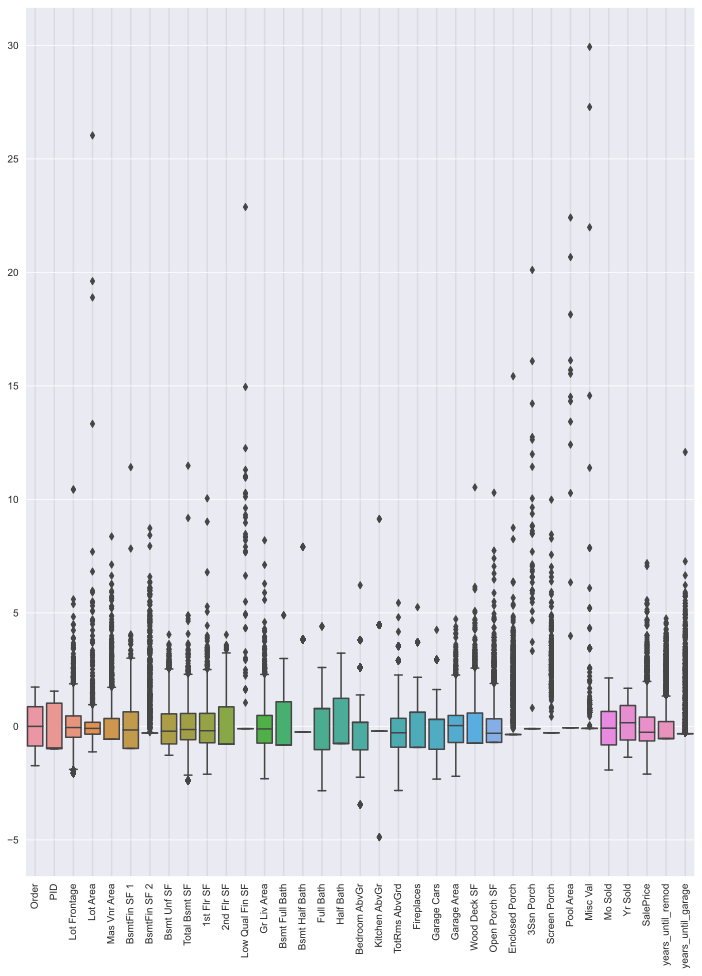


Value Distribution ---  AFTER DROP COLUMNS


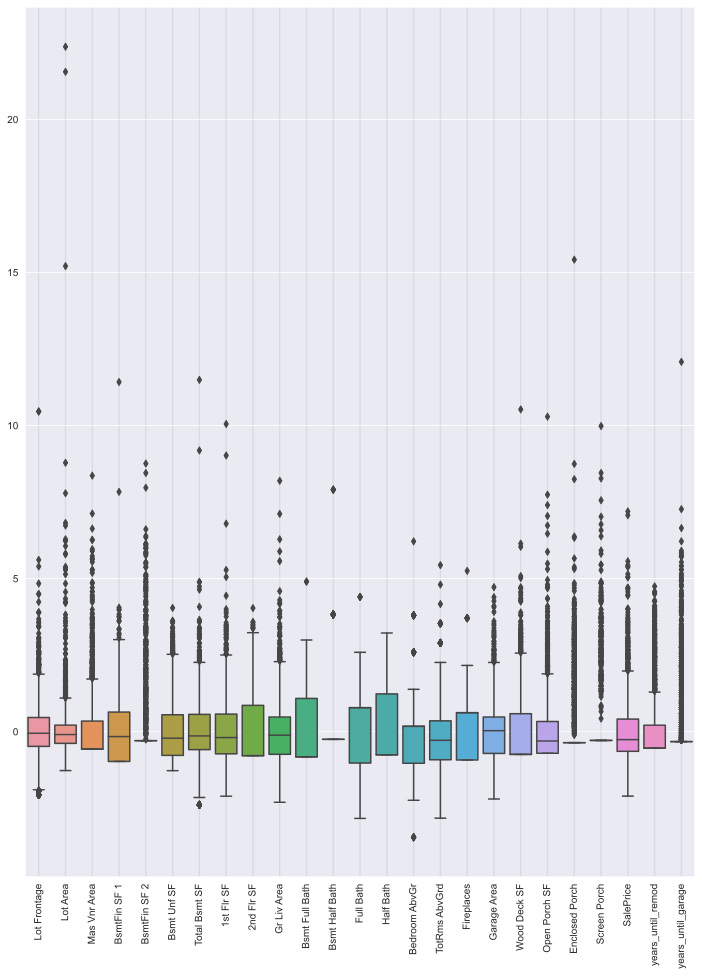

In [12]:
def plot_distributions(data, label):
    numeric = data.select_dtypes('number')
    print('\nValue Distribution --- ', label)
    z_scores = (numeric - numeric.mean()) / numeric.std(ddof=0)
    
    plt.figure(figsize=(12,16))
    ax = sns.boxplot(data=z_scores, orient='v')
    plt.setp(ax.get_xticklabels(), rotation=90)
    [ax.axvline(x,color='#00000011', zorder=0) for x in ax.get_xticks()]
    plt.show()

t_houses = transform_features(houses, log = {
    'after_new_features': plot_distributions,
    'after_drop_columns': plot_distributions,
})

### 2. Select Features

**removing highly correlated non-target columns**

In [13]:
def plot_corr(df, label, thresh = 0, **kwargs):
    plt.figure(figsize=(9, 7))
    corr = df.corr()
    inv_identity = np.invert(np.identity(len(corr), dtype='bool')).astype('float')
    inv_corr = corr * inv_identity
    selection_cols = corr[inv_corr.abs().max() > thresh].index
    if len(list(selection_cols)) == 0:
        print(label + '\n' + 'No columns with correlation >', thresh)
        return
    selection = corr.loc[selection_cols, selection_cols]
    matrix = np.triu(selection)
    ax = sns.heatmap(selection, mask=matrix, vmin=-1, vmax=1, 
                     square=True, annot=True, cbar=False,
                     linewidth=0.4, linecolor='white', **kwargs);
    ax.set_title(label + '\n' + 'Correlation > ' + str(thresh))
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    plt.show();

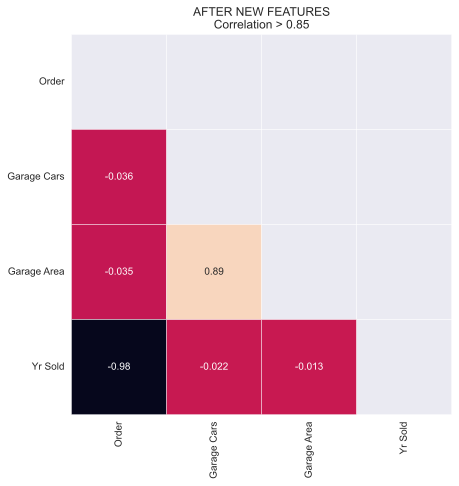

AFTER DROP COLUMNS
No columns with correlation > 0.85
AFTER FILL AND RESCALE
No columns with correlation > 0.85


<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

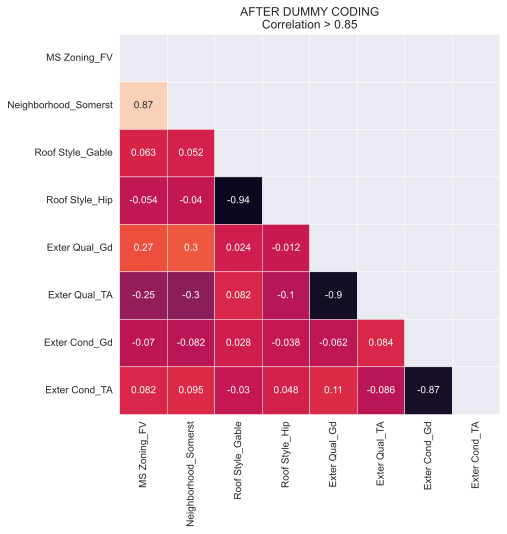

AFTER HIGH CORR DROP 
No columns with correlation > 0.85


<Figure size 648x504 with 0 Axes>

In [14]:
def plot_high_corr(df, label):
    plot_corr(df, label, thresh = 0.85)

transform_features(houses, log = {
    'after_new_features': plot_high_corr,
    'after_drop_columns': plot_high_corr,
    'after_fill_and_rescale': plot_high_corr,
    'after_dummy_coding': plot_high_corr,
    'after_high_corr_drop': plot_high_corr,
});

In [15]:
def select_features(data, target_col, thresh = 0):
    corr = transform_features(data).corr()
    target_corr = corr[target_col]
    high_target_corr = target_corr[target_corr.abs() > thresh]\
        .drop(target_col)
    sorted_high_corr = high_target_corr.iloc[
        (-high_target_corr.abs()).argsort()
    ]
    return sorted_high_corr

### 3. Train & Test

In [16]:
from itertools import permutations
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit

In [17]:
def rmse_score(true_values, predictions):
    return (
        mean_squared_error(true_values, predictions) / len(true_values)
    ) ** 1/2

def get_scores(true_vals, predicted_vals, score_fns = [rmse_score]):
    return [score_fn(true_vals, predicted_vals) for score_fn in score_fns]

def train_and_test_model(data, target_data, feature_cols = None, scoring = [], **kwargs):
    target_col = target_data.name
    transformed_data = transform_features(data).select_dtypes('number')
    transformed_data[target_col] = target_data
    
    scores =  [
        cross_val_score(
            LinearRegression(),
            transformed_data[feature_cols],
            transformed_data[target_col],
            scoring = score,
            **kwargs
        ) for score in scoring
    ]
    
    return scores

In [18]:
def holdout_validation(data, target_data, random_state=None, **kwargs):
    cv = ShuffleSplit(n_splits=1, test_size=.25, random_state=random_state)
    
    return train_and_test_model(
            data = data,
            target_data = target_data,
            cv = cv,
            **kwargs
        )

def kfold_cross_validation(k, *args, random_state=None, **kwargs):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    return train_and_test_model(
        *args,
        cv = kf,
        **kwargs
    )

In [19]:
def train_and_test(df, target_col, k = 1, random_state = 0, **kwargs):
    data = df.copy()
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    target_data = data[target_col]
    
    if (k == 1): return holdout_validation(data, target_data, **kwargs)
    if (k > 1): return kfold_cross_validation(k, data, target_data, **kwargs)

## Optimizing the model

In [20]:
best_features = select_features(houses, 'SalePrice', 0.4)
best_features_df = best_features.to_frame('target corr')
best_features_df['rank'] = range(1, best_features_df.shape[0] + 1)
best_features_df.index.rename('feature', inplace=True)
print(best_features_df.reset_index().set_index('rank'))

                   feature  target corr
rank                                   
1              Gr Liv Area      0.70675
2              Garage Area      0.64063
3            Total Bsmt SF      0.63178
4               1st Flr SF      0.62098
5                Full Bath      0.54556
6          Kitchen Qual_TA     -0.52815
7         Foundation_PConc      0.52231
8             Mas Vnr Area      0.50320
9            TotRms AbvGrd      0.49524
10              Fireplaces      0.47362
11          Overall Qual_9      0.45775
12           Exter Qual_Gd      0.44757
13    Neighborhood_NridgHt      0.43395
14            BsmtFin SF 1      0.43236
15          Overall Qual_8      0.41630


In [34]:
def plot_test_results(results, plot_score = 'r2'):
    heatmap_data = results.pivot(
        index='k', columns='num_best_features', values=plot_score
    )
    plt.figure(figsize=(16,12))
    plt.title('Scoring: ' + plot_score)
    ax = sns.heatmap(heatmap_data, square=True, annot=True, cbar=False,
               linewidth=0.2, linecolor='white', fmt='.2f', cmap='PiYG');
    plt.yticks(rotation=0)

In [28]:
def run_tests(df, target_col, k_range, best_features_range, plot='rmse', scoring=[]):
    from sklearn.metrics import r2_score, mean_absolute_error
    
    features_corr = select_features(houses, target_col).index.tolist()
    
    results = []

    for idx, k in enumerate(k_range):
        for features in [features_corr[:n] for n in best_features_range]:
            scores = train_and_test(
                houses, target_col, k, 
                feature_cols = features, 
                scoring = ['neg_mean_squared_error'] + scoring,
                random_state = idx
            )
            summary_dict = {
                'k': k, 
                'num_best_features': len(features), 
            }
            scoring_dict = {
                'rmse': np.mean(np.sqrt(np.abs(scores[0])))
            }
            
            mean_scores = [ np.mean(data) for data in scores[1:] ]
            user_scoring_dict = scoring and dict(
                zip(scoring, mean_scores)
            ) or {}
            
            scoring_dict.update(user_scoring_dict)
            summary_dict.update(scoring_dict)
            
            results.append(summary_dict)
            
    results_df = pd.DataFrame(results)

    if plot:
        plot_test_results(results_df, plot_score=plot)

    return results_df

CPU times: user 27.9 s, sys: 904 ms, total: 28.8 s
Wall time: 9.49 s


<AxesSubplot:xlabel='num_best_features'>

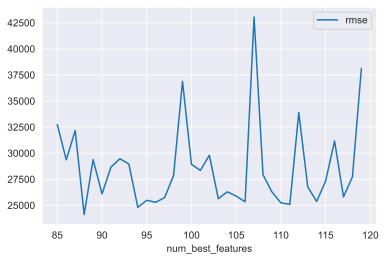

In [29]:
%%time
import time

k_range = [1]
best_features_range = range(85, 120)

results = run_tests(houses, 'SalePrice', k_range, best_features_range, 
          scoring=['r2', 'neg_mean_squared_error'], plot=False)
results.plot.line('num_best_features', 'rmse')

CPU times: user 8.23 s, sys: 288 ms, total: 8.52 s
Wall time: 3.33 s


<AxesSubplot:xlabel='num_best_features'>

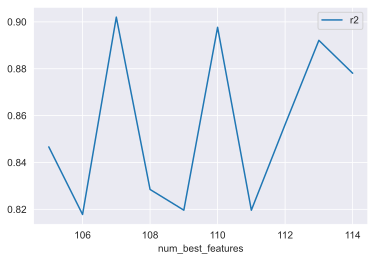

In [24]:
%%time
import time

k_range = [1]
best_features_range = range(105, 115)

results = run_tests(houses, 'SalePrice', k_range, best_features_range, 
          scoring=['r2', 'neg_mean_squared_error'], plot=False)
results.plot.line('num_best_features', 'r2')

CPU times: user 13.8 s, sys: 443 ms, total: 14.2 s
Wall time: 5.03 s


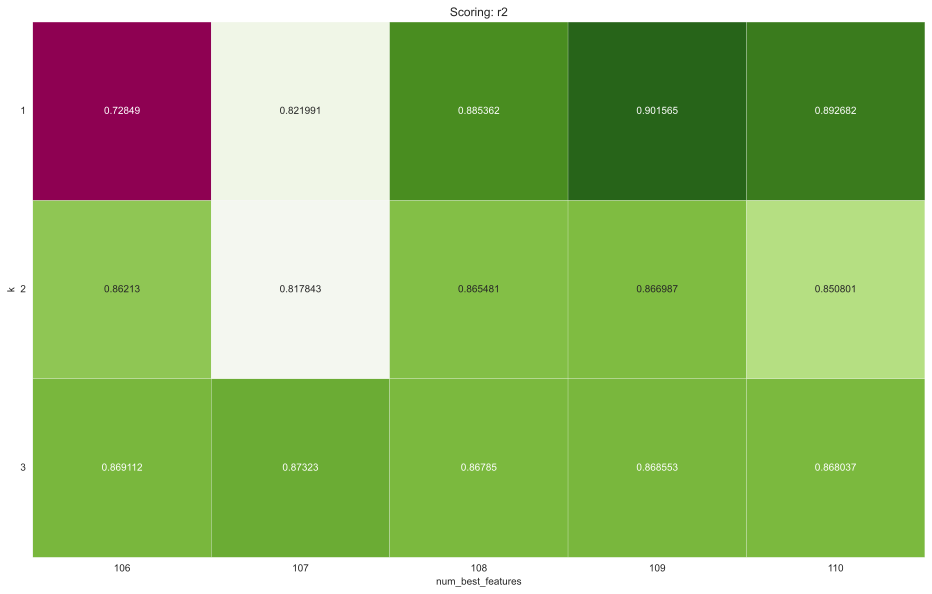

In [32]:
%%time
import time

k_range = range(1, 4)
best_features_range = range(106, 111)

results = run_tests(houses, 'SalePrice', k_range, best_features_range, 
          scoring=['r2', 'neg_mean_squared_error'], plot='r2')

### Stored calculations

K: **1 - 5**  
best features: **2 - 26**  
Wall time: 2min 26s

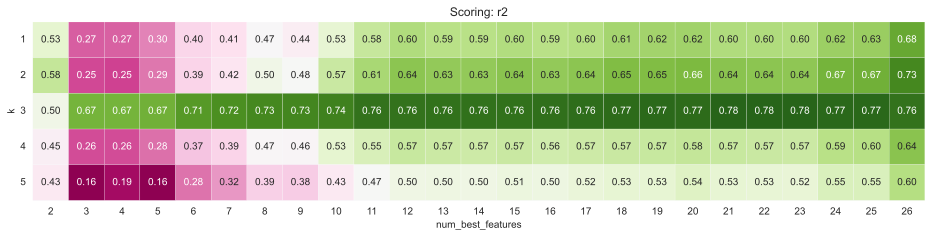

In [35]:
k1_5f2_26 = pd.read_pickle('./k1_5f2_26.pkl')
plot_test_results(k1_5f2_26)